<a href="https://colab.research.google.com/github/mrzhuzhe/pepper/blob/master/colabNote/f1score_%26_learning_cosine_rate_schedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#F1score

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score([1,0,0], [1,0,0], average=None)

array([1., 1.])

# Cross Entropy

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [ ]:
np.array([0,1]).argsort(-1)[::-1]

array([1, 0])

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
loss = F.cross_entropy(input, target)

In [ ]:
input

tensor([[ 1.5320,  1.2220,  0.6095, -1.3303,  0.5052],
        [-0.7996,  0.5411, -1.9048, -0.8340,  1.9317],
        [ 0.4908, -0.1125, -0.4168,  1.4466, -0.9091]], requires_grad=True)

In [ ]:
input.detach().numpy().argsort(-1)[:, ::-1]

array([[0, 1, 2, 4, 3],
       [4, 1, 0, 3, 2],
       [3, 0, 1, 2, 4]])

In [ ]:
target

tensor([3, 3, 2])

# Convert probility to one hot

In [ ]:
probability = np.random.random_sample((472, 6))
np.argmax(probability, 1).shape

(472,)

In [ ]:
oneHots = np.zeros((472, 6))
oneHots[6, np.argmax(probability, 1)] = 1  

In [ ]:
oneHots

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
m = nn.Sigmoid()
input = torch.randn(2, 3)
output = m(input)
input, output

(tensor([[-0.3505,  1.4295,  0.4421],
         [ 0.1126,  1.4978, -1.3529]]), tensor([[0.4133, 0.8068, 0.6088],
         [0.5281, 0.8173, 0.2054]]))

In [ ]:
F.one_hot(torch.arange(0, 5) % 3)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]])

In [ ]:
F.one_hot(torch.argmax(output, 1), num_classes=6)

tensor([[0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]])

In [ ]:
probs = torch.randn(21, 512, 512)
max_idx = torch.argmax(probs, 0, keepdim=True)
one_hot = torch.FloatTensor(probs.shape)
one_hot.zero_()
one_hot.scatter_(0, max_idx, 1)

tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

# CosineLRScheduler learning rate

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import Adam

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts 

In [5]:
!pip install timm

     |████████████████████████████████| 376 kB 8.7 MB/s 


In [6]:
import timm
from timm.models.swin_transformer import *

In [51]:
from timm.scheduler.cosine_lr import CosineLRScheduler

In [10]:
num_label = 6
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #self.swin = swin_base_patch4_window12_384_in22k(pretrained=True)
        e = swin_tiny_patch4_window7_224(pretrained=True, drop_path=0.2)
        self.patch_embed = e.patch_embed
        self.pos_drop = e.pos_drop
        self.layers = e.layers
        self.norm = e.norm
        self.avgpool = e.avgpool
        
        self.logit = nn.Linear(768, num_label)
        


    # @torch.cuda.amp.autocast()
    def forward(self, image):
        batch_size = len(image)
        x = 2*image-1     ; #print('input ',   x.shape)

        x = self.patch_embed(x)
        x = self.pos_drop(x)
        x = self.layers(x)
        x = self.norm(x)  # B L C
        # TODO ？？？？
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        logit = self.logit(x)
        return logit

In [12]:
def get_learning_rate(optimizer):
    lr=[]
    for param_group in optimizer.param_groups:
        lr +=[ param_group['lr'] ]

    assert(len(lr)==1) #we support only one param_group
    lr = lr[0]

    return lr

In [64]:
net = Net()
optimizer = Adam(net.parameters(), lr=5e-4)
T_0 = 20
eta_min = 1e-4
lrs = []
scheduler = lr_scheduler = CosineLRScheduler(
            optimizer,
            t_initial=20*1000,
            t_mul=1.,
            lr_min=5e-6,
            warmup_lr_init=5e-7,
            warmup_t=1*1000,
            cycle_limit=1,
            t_in_epochs=False,
        )
#iters = len(dataloader)
for epoch in range(20):
     #for i, sample in enumerate(dataloader):
         #inputs, labels = sample['inputs'], sample['labels']
         #optimizer.zero_grad()
         #outputs = net(inputs)
         #loss = criterion(outputs, labels)
         #loss.backward()
    for i in range(1000):
         optimizer.step()
         rate = get_learning_rate(optimizer)
         lrs.append(rate)
         scheduler.step_update(epoch*1000 + i)

In [17]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'lr')

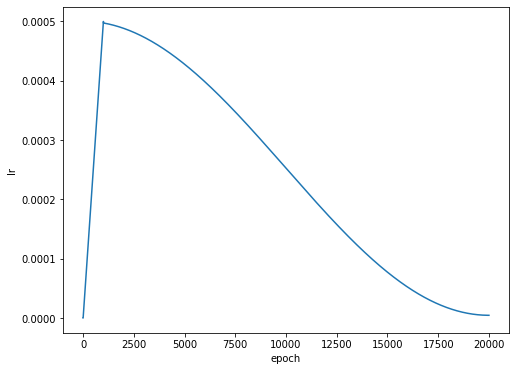

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(range(20*1000), lrs[:20*1000])
plt.xlabel('epoch')
plt.ylabel('lr')